# Agent 1

In [108]:
import sys
import subprocess
import uuid
import re
from pathlib import Path
from typing import TypedDict
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage

load_dotenv()

True

In [109]:
class AgentState(TypedDict):
    user_query: str
    generated_code: str
    scene_name : str
    execution_output: dict
    final_answer: str
    video_path: str
    retry_count: int
    max_retries: int
    error_history: list  # Track all errors
from pydantic import BaseModel

class CodeOutput(BaseModel):
    code: str
    
class ExpandedPrompt(BaseModel):
    expanded_prompt: str

In [128]:

# -----------------------------
# LLM (Gemini 2.5 Flash)
# -----------------------------

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

In [129]:
def prompt_expander_node(state: AgentState):
    base_template = f"""
    You are a prompt generator for a Manim animation code agent.

    Convert the following short user request into a detailed Manim generation prompt.

    The generated prompt must:
    - Enforce strict import rules
    - Use this as fix class name:{state['scene_name']}
    - Require VoiceoverScene inheritance
    - Use GTTS voice service
    - Enforce non-overlapping layout
    - Require subtitles + voiceover blocks
    - Enforce left/right axes layout
    - Disallow numeric axis labels
    - Require structured animation steps

    User short request:
    {state['user_query']}

    Return ONLY the expanded prompt text.
    """

    structured_llm = llm.with_structured_output(ExpandedPrompt)
    response = structured_llm.invoke([HumanMessage(content=base_template)])

    return {
        **state,
        "user_query": response.expanded_prompt  # Replace with expanded prompt
    }


In [112]:
# -----------------------------
# Node 1 – generate python code
# -----------------------------

def code_generator_node(state: AgentState):
    scene_name = state["scene_name"]
    prompt = f"""
You are a python code generator for Manim animations.

STRICT RULE:
The class name MUST be exactly: {scene_name}

Write ONLY valid python code.
Do not add explanations.
Do not add markdown.
Import all necessary modules.

User request:
{state["user_query"]}
"""
    structured_llm = llm.with_structured_output(CodeOutput)
    response = structured_llm.invoke([HumanMessage(content=prompt)])

    return {
        **state,
        "generated_code": response.code,
        "retry_count": 0,
        "max_retries": 3,
        "error_history": []
    }

In [113]:
# -----------------------------
# Node 2 – Code Fixer (NEW!)
# -----------------------------

def code_fixer_node(state: AgentState):
    """Fix code based on error feedback"""

    if state["execution_output"]["returncode"] != 0:

        last_error = state["execution_output"].get("stderr", "")
        previous_code = state["generated_code"]

        prompt = f"""
You are a python code debugger.

The following Manim code has an ERROR:

{previous_code}

ERROR:
{last_error}

Previous errors fixed:
{chr(10).join(state["error_history"][-3:]) if state["error_history"] else "None"}

Fix the code by:
1. Adding missing imports
2. Fixing undefined variables/constants
3. Correcting syntax errors
4. Ensuring all Manim constants are properly imported

Return ONLY valid corrected python code.
"""

        structured_llm = llm.with_structured_output(CodeOutput)
        response = structured_llm.invoke(prompt)

        new_error_history = state["error_history"] + [last_error]

        return {
            **state,
            "generated_code": response.code,
            "retry_count": state["retry_count"] + 1,
            "error_history": new_error_history
        }

    return state


In [114]:
# -----------------------------
# helpers for runner
# -----------------------------

def save_code_to_file(code: str) -> Path:
    "save code to tmp file"
    path = Path("tmp")
    path.mkdir(exist_ok=True)

    file_path = path / f"{uuid.uuid4().hex}.py"
    file_path.write_text(code, encoding="utf-8")

    return file_path

def extract_manim_scene(code: str) -> str | None:
    pattern = r"class\s+(\w+)\s*\([^)]*Scene[^)]*\)\s*:"
    match = re.search(pattern, code)
    if match:
        return match.group(1)
    return None

def find_generated_mp4() -> Path | None:
    """Find the most recently generated MP4 file in media/videos."""
    media_path = Path("media/videos")
    if not media_path.exists():
        return None
    
    mp4_files = list(media_path.rglob("*.mp4"))
    if not mp4_files:
        return None
    
    return max(mp4_files, key=lambda p: p.stat().st_mtime)

def run_manim_file(path: Path, scene_name: str):
    try:
        result = subprocess.run(
        [
            sys.executable,
            "-m",
            "manim",
            "-pql",
            str(path),
            scene_name
        ],
        capture_output=True,
        text=True,
        encoding="utf-8",   # ADD THIS
        errors="ignore",    # OPTIONAL SAFETY
        timeout=180
    )


        video_path = None
        if result.returncode == 0:
            video_path = find_generated_mp4()

        return {
            "stdout": result.stdout,
            "stderr": result.stderr,
            "returncode": result.returncode,
            "video_path": str(video_path) if video_path else None
        }

    except subprocess.TimeoutExpired:
        return {
            "stdout": "",
            "stderr": "Manim rendering timed out",
            "returncode": -1,
            "video_path": None
        }


In [115]:
# -------------------------------------------------
# Node 3 – Code Runner
# -------------------------------------------------

def code_runner_node(state):
    code = state["generated_code"]
    path = save_code_to_file(code)

    scene_name = state["scene_name"]

    if scene_name is not None:
        output = run_manim_file(path, scene_name)
    else:
        output = {
            "stdout": "",
            "stderr": "No Scene class found in generated code",
            "returncode": -1,
            "video_path": None
        }

    return {
        **state,
        "execution_output": output,
        "video_path": output.get("video_path", "")
    }


In [116]:
# -----------------------------
# Node 4 – Check if needs retry
# -----------------------------

def should_retry(state: AgentState) -> str:
    """Decide if we should retry or finish"""
    
    output = state["execution_output"]
    
    # Success case
    if output["returncode"] == 0:
        return "final_answer"
    
    # Failed but can retry
    if state["retry_count"] < state["max_retries"]:
        print(f"\n⚠️  Error detected. Retry {state['retry_count'] + 1}/{state['max_retries']}")
        return "code_fixer"
    
    # Failed and out of retries
    return "final_answer"

In [117]:
# -----------------------------
# Node 5 – final answer node
# -----------------------------

def final_answer_node(state: AgentState):
    out = state["execution_output"]

    if out["returncode"] != 0:
        answer = f"""❌ Failed after {state['retry_count']} retries.

Last Error:
{out['stderr']}

All errors encountered:
{chr(10).join(f"{i+1}. {err[:100]}..." for i, err in enumerate(state["error_history"]))}
"""
    else:
        answer = f"""✅ Animation generated successfully after {state['retry_count']} retries!

Video: {state['video_path']}

Errors fixed: {len(state['error_history'])}
"""

    return {
        **state,
        "final_answer": answer
    }


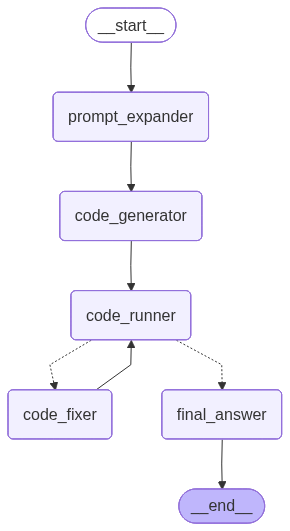

In [122]:
graph = StateGraph(AgentState)

# Add all nodes
graph.add_node("prompt_expander", prompt_expander_node)
graph.add_node("code_generator", code_generator_node)
graph.add_node("code_fixer", code_fixer_node)
graph.add_node("code_runner", code_runner_node)
graph.add_node("final_answer", final_answer_node)

# Set entry point
graph.set_entry_point("prompt_expander")

# Initial generation flow
graph.add_edge("prompt_expander", "code_generator")
graph.add_edge("code_generator", "code_runner")

# Conditional: retry or finish
graph.add_conditional_edges(
    "code_runner",
    should_retry,
    {
        "code_fixer": "code_fixer",
        "final_answer": "final_answer"
    }
)

# Fix and retry
graph.add_edge("code_fixer", "code_runner")

# End
graph.add_edge("final_answer", END)
graph.compile()

In [130]:

state = {
    "user_query": "Working of Deep Learning , also include voice and formulas",
    "generated_code": "",
    "scene_name" : "DeepLearningWorkingScene",
    "execution_output": {},
    "final_answer": "",
    "video_path": "",
    "retry_count": 0,
    "max_retries": 3,
    "error_history": []
}

state

{'user_query': 'Working of Deep Learning , also include voice and formulas',
 'generated_code': '',
 'scene_name': 'DeepLearningWorkingScene',
 'execution_output': {},
 'final_answer': '',
 'video_path': '',
 'retry_count': 0,
 'max_retries': 3,
 'error_history': []}

# Debug

In [131]:
state = prompt_expander_node(state)

print("Query")
print(state["user_query"])  

Query
Generate Manim Python code for an animation explaining the "Working of Deep Learning".

The animation must adhere to the following strict requirements:

1.  **Imports:** Only `from manim import *`, `from manim_voiceover import VoiceoverScene`, and `from manim_voiceover.services.gtts import GTTS` are allowed. No other imports are permitted.
2.  **Class Definition:** The main scene class must be named `DeepLearningWorkingScene` and must inherit from `VoiceoverScene`.
3.  **Voiceover Service:** Use `GTTS` for all voiceovers.
4.  **Layout:**
    *   Ensure a non-overlapping layout for all elements.
    *   Utilize a clear left/right axes layout for presenting concepts and their explanations.
    *   Numeric labels on axes are strictly forbidden.
5.  **Content:**
    *   Explain the core working principles of Deep Learning.
    *   Incorporate relevant mathematical formulas to illustrate key concepts (e.g., activation functions, loss functions, gradient descent).
    *   Include voice

In [132]:
state = code_generator_node(state)

print("Generated Code:\n")
print(state["generated_code"])  # preview first 500 chars I

Generated Code:

from manim import *
from manim_voiceover import VoiceoverScene
from manim_voiceover.services.gtts import GTTS

class DeepLearningWorkingScene(VoiceoverScene):
    def construct(self):
        self.set_speech_service(GTTS())

        # Title
        title = Text("Working of Deep Learning").to_edge(UP)
        self.play(Write(title))
        self.wait(0.5)

        # Introduction
        with self.voiceover(text="Deep Learning is a subfield of machine learning inspired by the structure and function of the human brain, specifically artificial neural networks.") as vo:
            intro_text = Text("Deep Learning: Inspired by the Human Brain").scale(0.7).next_to(title, DOWN, buff=0.8).to_edge(LEFT)
            self.play(Write(intro_text))
            self.wait(vo.duration)

        # Neural Network Visual (Simple)
        with self.voiceover(text="At its core, deep learning models are built from interconnected nodes called neurons, organized into layers.") as vo:
         

In [133]:
scene_name = extract_manim_scene(state["generated_code"])

print(scene_name)
print(type(scene_name))
print(len(scene_name))


DeepLearningWorkingScene
<class 'str'>
24


In [137]:
state = code_runner_node(state)

state

{'user_query': 'Generate Manim Python code for an animation explaining the "Working of Deep Learning".\n\nThe animation must adhere to the following strict requirements:\n\n1.  **Imports:** Only `from manim import *`, `from manim_voiceover import VoiceoverScene`, and `from manim_voiceover.services.gtts import GTTS` are allowed. No other imports are permitted.\n2.  **Class Definition:** The main scene class must be named `DeepLearningWorkingScene` and must inherit from `VoiceoverScene`.\n3.  **Voiceover Service:** Use `GTTS` for all voiceovers.\n4.  **Layout:**\n    *   Ensure a non-overlapping layout for all elements.\n    *   Utilize a clear left/right axes layout for presenting concepts and their explanations.\n    *   Numeric labels on axes are strictly forbidden.\n5.  **Content:**\n    *   Explain the core working principles of Deep Learning.\n    *   Incorporate relevant mathematical formulas to illustrate key concepts (e.g., activation functions, loss functions, gradient descent)

In [135]:
decision = should_retry(state)
print("Decision:", decision)


⚠️  Error detected. Retry 1/3
Decision: code_fixer


In [ ]:
state = code_fixer_node(state)

print("Retry Count:", state["retry_count"])
print("Fixed Code Preview:\n")
print(state["generated_code"][:500])

Retry Count: 1
Fixed Code Preview:

from manim import *
from manim_voiceover import VoiceoverScene
from manim_voiceover.services.gtts.gtts import GTTS

class DeepLearningWorkingScene(VoiceoverScene):
    def construct(self):
        self.set_speech_service(GTTS())

        # Title
        title = Text("Working of Deep Learning").to_edge(UP)
        self.play(Write(title))
        self.wait(0.5)

        # Introduction
        with self.voiceover(text="Deep Learning is a subfield of machine learning inspired by the structure and fu


In [105]:
state = final_answer_node(state)
print(state["final_answer"])

✅ Animation generated successfully after 0 retries!

Video: media\videos\253ef66d697e4659b03afcf4d488ec1d\480p15\LogisticRegressionScene.mp4

Errors fixed: 0



In [32]:
state["execution_output"]["returncode"]

0